# Sleep Stage Classification

As part of my <b>research project</b> with the graduate school, I had the opportunity to develop a <b>sleep stage classifier</b> using machine learning techniques. Sleep is characterized by <b>five types of brain waves</b>: delta, theta, alpha, sigma, and beta. For my model, I selected <b>power spectral density</b> (PSD) as a feature in the matrix, a method that has demonstrated promising results in previous studies [7]. Additionally, we showed that <b>multiscale entropy</b> (MSE) is an effective tool for distinguishing different sleep phases. Consequently, both of these mathematical tools were employed in our feature engineering process, with the MSE implementation in Python developed by myself.

The data utilized in this study were sourced from the <b>MNE library</b>, as the monkey sleep data initially available were too corrupted for reliable analysis.

### Importing Libraries

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pywt

from scipy.spatial.distance import pdist

import mne
from mne.datasets.sleep_physionet.age import fetch_data

<b>matplotlib.pyplot:</b> Used for creating visualizations.

<b>numpy:</b> A fundamental package for numerical computations in Python.

<b>pywt:</b> A library for discrete wavelet transform, often used in signal processing.

<b>scipy.spatial.distance.pdist:</b> Computes pairwise distances between points, used for clustering or other distance-based analyses.

<b>mne:</b> A library for processing and analyzing EEG and MEG data.

<b>mne.datasets.sleep_physionet.age.fetch_data:</b> A function to fetch sleep EEG data from the PhysioNet database.

### Looping Over Subjects to Fetch and Process Data

In [8]:
# Define the list of subjects (assuming subject IDs 0 to 19)
subject_ids = range(20)

# Dictionary mapping sleep stages to event IDs
annotation_desc_2_event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}

# List to store epochs from all subjects
all_raw_data = []
all_events_train = []
event_offset = 0

for subject in subject_ids:
    # Fetch data for the current subject
    [subject_files] = fetch_data(subjects=[subject], recording=[1])
    
    # Read raw data
    raw_train = mne.io.read_raw_edf(
        subject_files[0],
        stim_channel="Event marker",
        infer_types=True,
        preload=True,
        verbose="error"
    )
    
    # Read annotations
    annot_train = mne.read_annotations(subject_files[1])
    
    # Set annotations to raw data
    raw_train.set_annotations(annot_train, emit_warning=False)
    
    # Crop annotations (keep last 30-min wake events before sleep and first 30-min wake events after sleep)
    annot_train.crop(annot_train[1]["onset"] - 30 * 60, annot_train[-2]["onset"] + 30 * 60)
    raw_train.set_annotations(annot_train, emit_warning=False)
    
    # Extract events from annotations
    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.0
    )
    
    # Adjust event times by adding an offset
    events_train[:, 0] += event_offset
    
    # Update event_offset based on the duration of the current raw data
    event_offset += raw_train.n_times
    
    all_raw_data.append(raw_train)
    all_events_train.append(events_train)
    
    
# Concatenate all raw data
all_raw_data = mne.concatenate_raws(all_raw_data)

# Combine all events
all_events_train = np.concatenate(all_events_train, axis=0)

# Create a new event_id that unifies stages 3 and 4
event_id = {
        "Sleep stage W": 1,
        "Sleep stage 1": 2,
        "Sleep stage 2": 3,
        "Sleep stage 3/4": 4,
        "Sleep stage R": 5,
        }
    
# Define tmax for epochs
tmax = 30.0 - 1.0 / all_raw_data.info["sfreq"]  # tmax is inclusive
    
# Create epochs
epochs = mne.Epochs(
        raw=all_raw_data,
        events=all_events_train,
        event_id=event_id,
        tmin=0.0,
        tmax=tmax,
        baseline=None,
    )
    
# Delete raw_train to free up memory (optional)
del all_raw_data 

Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used 

### Features Engineering

In [9]:
def multiscale_sample_entropy(x, m=2, r=0.15, tau=1):
    """
    Multiscale Sample Entropy
    """

    # Coarse signal
    y = np.mean(np.reshape(x[:len(x) // tau * tau], (tau, -1)), axis=0)
    
    # (m+1)-element sequences
    X = np.array([y[i:i + m + 1] for i in range(len(y) - m)])
    
    # Matching (m+1)-element sequences
    chebyshev_dist = pdist(X, metric='chebyshev')
    A = np.sum(chebyshev_dist < r * np.nanstd(x, ddof=1))
    
    # Matching m-element sequences
    X = X[:, :-1]
    chebyshev_dist = pdist(X, metric='chebyshev')
    B = np.sum(chebyshev_dist < r * np.nanstd(x, ddof=1))
    
    # Take log
    if A == 0 or B == 0:
        return np.nan
    
    e = np.log(B / A)
    
    return e

In [10]:
def features_matrix(epochs):
    # Specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    # Compute PSD
    spectrum = epochs.compute_psd(picks=[1], fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    # Extract band power features
    X_freq = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X_freq.append(psds_band)

    # Concatenate all frequency band features
    X_freq = np.concatenate(X_freq, axis=1)
    
    # Compute entropy and wavelet features for each epoch
    X_entropy = []
    for epoch in epochs.get_data():
        entropy_values = []
        entropy_value = multiscale_sample_entropy(epoch[1, :], m=2, r=0.2)  # MSE EEG channels
        if not np.isnan(entropy_value):
            entropy_values.append(entropy_value)            
        else:
            entropy_values.append(0)
        X_entropy.append(entropy_values)
        
    # Ensure X_entropy is 2D arrays for concatenation
    X_entropy = np.array(X_entropy)
    
    # Concatenate frequency features, entropy features, and wavelet features
    X = np.concatenate([X_freq, X_entropy], axis=1)

    return X

### Machine learning

In [11]:
X, y = features_matrix(epochs), epochs.events[:, 2]

Using data from preloaded Raw for 21357 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 21357 events and 3000 original time points ...


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

Histogram-Based Gradient Boosting 74.75% accuracy with a standard deviation of 2.87%
GradientBoostingClassifier 71.42% accuracy with a standard deviation of 3.54%
Random Forest 74.42% accuracy with a standard deviation of 2.57%
ExtraTreesClassifier 73.97% accuracy with a standard deviation of 2.50%


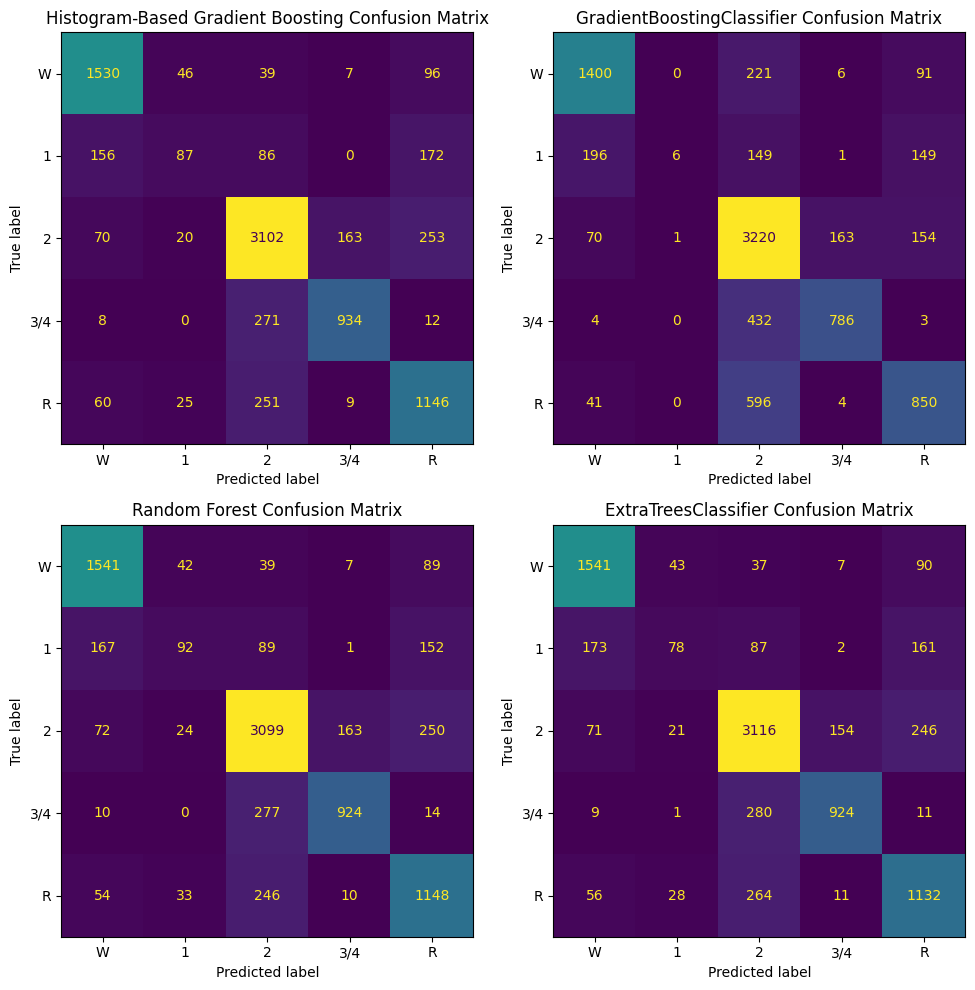

In [13]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score

names = [
    "Histogram-Based Gradient Boosting",
    "GradientBoostingClassifier",
    "Random Forest",
    "ExtraTreesClassifier"
]


classifiers = [
    HistGradientBoostingClassifier(),
    GradientBoostingClassifier(learning_rate=0.01),
    RandomForestClassifier(n_estimators=100),
    ExtraTreesClassifier(n_estimators=100)
]

# Create a new event_id that unifies stages 3 and 4
event_name = {
        "W": 1,
        "1": 2,
        "2": 3,
        "3/4": 4,
        "R": 5,
        }

# Créer une figure avec 2x2 sous-plots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Boucle sur les classificateurs
for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, X, y, cv=5)
    print(f"{name} {scores.mean()*100:<0.2f}% accuracy with a standard deviation of {scores.std()*100:<0.2f}%")
    
for idx, (name, clf) in enumerate(zip(names, classifiers)):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
    
    # Sélectionner l'axe approprié dans le subplot 2x2
    ax = axs[idx // 2, idx % 2]
    
    # Afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=event_name.keys())
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")

# Ajuster l'espacement pour éviter le chevauchement
plt.tight_layout()
plt.show()


In [14]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.84      0.90      0.87      1718
  Sleep stage 1       0.49      0.19      0.27       501
  Sleep stage 2       0.83      0.86      0.84      3608
Sleep stage 3/4       0.84      0.76      0.80      1225
  Sleep stage R       0.70      0.77      0.73      1491

       accuracy                           0.80      8543
      macro avg       0.74      0.69      0.70      8543
   weighted avg       0.79      0.80      0.79      8543



The model was evaluated using the <b>cross_val_score method</b>, applied to five variations of the training matrix to obtain a more accurate estimate of classifier performance. The results are encouraging, with an average accuracy of <b>73,64%</b> across the four classifiers tested. However, a more detailed analysis of the RandomForest classifier reveals difficulty in identifying stage 1 sleep, with an <b>F1-score of 0.27</b>.

This project, conducted during my first year of the master's program (M1), provided me with an initial experience in applying machine learning to biomedical problems. This work is particularly important in the context of Parkinson's disease, where sleep cycle disruptions are common. Accurate classification of sleep stages is crucial for assessing disease progression and the effectiveness of administered treatments.

<h3>References</h3>

[1](1,2)
Stanislas Chambon, Mathieu N. Galtier, Pierrick J. Arnal, Gilles Wainrib, and Alexandre Gramfort. A deep learning architecture for temporal sleep stage classification using multivariate and multimodal time series. IEEE Transactions on Neural Systems and Rehabilitation Engineering, 26(4):758–769, 2018. doi:10.1109/TNSRE.2018.2813138.

[2](1,2)
B. Kemp, A. H. Zwinderman, B. Tuk, H. A. C. Kamphuisen, and J. J. L. Oberyé. Analysis of a sleep-dependent neuronal feedback loop: the slow-wave microcontinuity of the EEG. IEEE Transactions on Biomedical Engineering, 47(9):1185–1194, 2000. doi:10.1109/10.867928.

[3](1,2)
Ary L. Goldberger, Luis A. N. Amaral, Leon Glass, Jeffrey M. Hausdorff, Plamen Ch. Ivanov, Roger G. Mark, Joseph E. Mietus, George B. Moody, Chung-Kang Peng, and H. Eugene Stanley. PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation, 2000. doi:10.1161/01.CIR.101.23.e215.

[4](1,2)
https://sapienlabs.org/lab-talk/understanding-multiscale-entropy/

[5](1,2)
"Multiscale entropy analysis of biological signals" By Madalena Costa, Ary L. Goldberger, and C.-K. Peng Published on 18 February 2005 in Phys. Rev. E 71, 021906.

[6](1,2)
Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: components of a new research resource for complex physiologic signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/cgi/content/full/101/23/e215]; 2000 (June 13)

[7](1,2)
https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html